In [1]:
import os
import torch
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from google.colab import drive
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
# Load the dataset (make sure it's in the correct folder)
df = pd.read_csv("/content/drive/My Drive/DSC 514 NLP/sampled_data.csv")

# Check the first few rows
df.head()

,movie_id,plot_summary,duration,genre,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,rating_y,review_summary,whole_review
0,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,1 February 2006,ur5945598,True,Oh where can I start on why alleged comedians ...,10,Chaplin strikes comic gold!,Oh where can I start on why alleged comedians ...
1,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,11 August 2005,ur5805910,True,"We follow ""the little fellow"" (Chaplin), in hi...",10,Chaplin's delightful bonhomie & innocence,"We follow ""the little fellow"" (Chaplin), in hi..."
2,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,22 June 2000,ur0773000,False,I recently saw this movie with a live orchestr...,9,"As fresh, funny, and moving as the day it was ...",I recently saw this movie with a live orchestr...
3,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,9 March 2009,ur0361658,False,The Gold Rush (1925) was a big undertaking for...,10,The Cinema of Charles Chaplin: The Gold Rush,The Gold Rush (1925) was a big undertaking for...
4,tt0017136,"Sometime in the future, the city of Metropolis...",2h 33min,"['Drama', 'Sci-Fi']",8.3,1927-03-13,"The film is set in the year 2026, in the extra...",7 March 2015,ur13977076,True,This sci-fi classic is set in a future where t...,10,A science fiction classic,This sci-fi classic is set in a future where t...


In [4]:
# Define features (X) and labels (y)
X = df["review_text"]  # Replace with the actual column containing the reviews
y = df["is_spoiler"]   # Replace with the actual column for labels (0 = non-spoiler, 1 = spoiler)

# Split into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
X_train

,review_text
2336,The Count of Monte Cristo is a splendid film t...
4778,The Hunger Games: Mockingjay Part 1 is a good ...
28,It's easy to see why this film appealed to int...
115,"At first, the premise and the beginning of thi..."
3413,"The play was not great at all, the actors were..."
...,...
2095,This movie was considerer by Premiere as one o...
1953,This movie was just way too boring for me. I c...
1537,"Written, both screenplay and original literary..."
895,Carlito's Way is without a doubt one of the gr...


In [6]:
y_train

,is_spoiler
2336,True
4778,False
28,True
115,False
3413,True
...,...
2095,False
1953,True
1537,True
895,False


In [7]:
# Convert back to DataFrame
df_train = pd.DataFrame({"review_text": X_train, "is_spoiler": y_train})
df_test = pd.DataFrame({"review_text": X_test, "is_spoiler": y_test})

In [8]:
df_train

,review_text,is_spoiler
2336,The Count of Monte Cristo is a splendid film t...,True
4778,The Hunger Games: Mockingjay Part 1 is a good ...,False
28,It's easy to see why this film appealed to int...,True
115,"At first, the premise and the beginning of thi...",False
3413,"The play was not great at all, the actors were...",True
...,...,...
2095,This movie was considerer by Premiere as one o...,False
1953,This movie was just way too boring for me. I c...,True
1537,"Written, both screenplay and original literary...",True
895,Carlito's Way is without a doubt one of the gr...,False


In [9]:
label2id = {'False': 0, 'True': 1}
id2label = {0: 'False', 1: 'True'}

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# Convert Pandas DataFrame to Hugging Face Dataset format
ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)

# Store in DatasetDict
ds = DatasetDict()
ds["train"] = ds_train
ds["validation"] = ds_test

Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1376 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

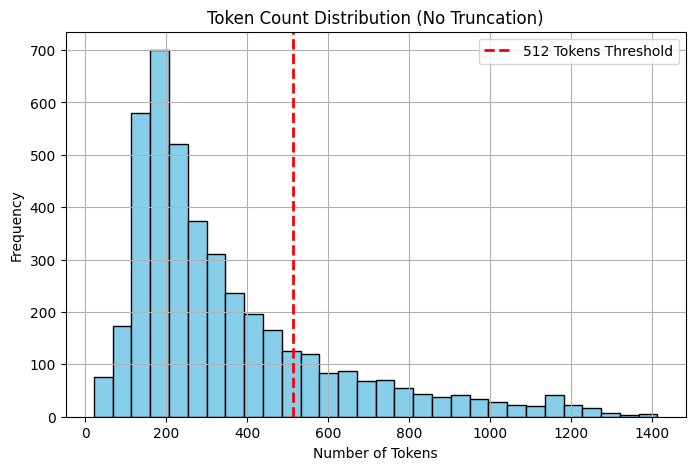

Number of entries exceeding 512 tokens: 861


In [13]:
model_name = "roberta-base"

# Initialize tokenizer
tokenizerbefore = RobertaTokenizerFast.from_pretrained("roberta-base", do_lower_case=True)

# Tokenize without truncation to capture full token count
def tokenize_without_truncation(batch):
    return tokenizerbefore(batch["review_text"], padding=False, truncation=False)

# Tokenize the dataset
ds_full_tokens = ds.map(tokenize_without_truncation, batched=True, batch_size=None)

# Calculate token counts
ds_full_tokens = ds_full_tokens.map(lambda x: {"token_count": len(x["input_ids"])})

# Extract token counts for plotting
token_counts2 = [entry['token_count'] for entry in ds_full_tokens['train']]

import matplotlib.pyplot as plt

# Plotting token distribution
plt.figure(figsize=(8, 5))
plt.hist(token_counts2, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='512 Tokens Threshold')

plt.title('Token Count Distribution (No Truncation)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Display the number of entries exceeding 512 tokens
exceeding_512 = [entry for entry in ds_full_tokens['train'] if entry['token_count'] > 512]
print(f"Number of entries exceeding 512 tokens: {len(exceeding_512)}")

In [14]:
tokenizer = RobertaTokenizerFast.from_pretrained(model_name, do_lower_case=True,
                                                 truncation=True, padding=True,
                                                 max_length=512)

def tokenize(batch):
    return tokenizer(batch["review_text"], padding=True, truncation=True,
                     max_length=512)

ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

In [15]:
ds_encoded = ds_encoded.map(lambda x: {"labels": int(x["is_spoiler"])})

Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

In [16]:
# Convert labels to tensor-compatible format
ds_encoded = ds_encoded.map(lambda x: {"labels": torch.tensor(x["labels"], dtype=torch.long)})


Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

In [17]:
print(ds_encoded["train"].column_names)

['review_text', 'is_spoiler', '__index_level_0__', 'input_ids', 'attention_mask', 'labels']


In [18]:
print(ds_encoded["train"][0])

{'review_text': 'The Count of Monte Cristo is a splendid film that captures its audience and maintains its interest throughout the film. The entire cast was fantastic, but the film also focused on the plot. Far too many movies these days focus too much on special effects with weak plots.There are Spoilers here, so I suggest watching the film before reading further.The Count presents a solid plot, and it\'s a complex plot at that. Many films have a single plot that builds up, climaxes and is then resolved. Not in the Count. The Count has a central plot, sure, and that is Edmond Dantès\' quest for vengeance against those who wronged him. But the Count also presents us with several sub-plots.At first glance, it seems that Edmond was imprisoned for treason by his first mate, Danglars, betraying him. Although Villefort cleared Edmond of all the charges, he has him rearrested after Edmond mentions the name Clarion. His best friend, Fernand Mondego, hasn\'t even been brought in to this conspi

In [19]:
# Extract token counts from 'input_ids'
ds_encoded['train'] = ds_encoded['train'].map(lambda x: {"token_count": len(x["input_ids"])})

# Collect token counts
token_counts = [entry['token_count'] for entry in ds_encoded['train']]

Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

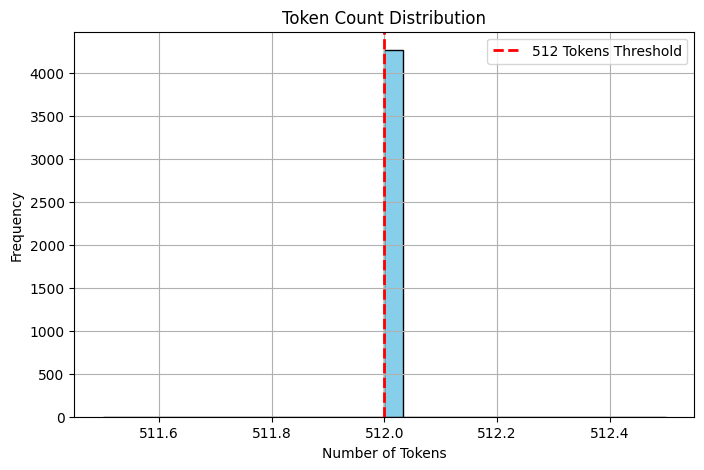

Number of entries exceeding 512 tokens: 0


In [20]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 5))
plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='512 Tokens Threshold')

plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Display entries exceeding 512 tokens
exceeding_512 = [entry for entry in ds_encoded['train'] if entry['token_count'] > 512]
print(f"Number of entries exceeding 512 tokens: {len(exceeding_512)}")


Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

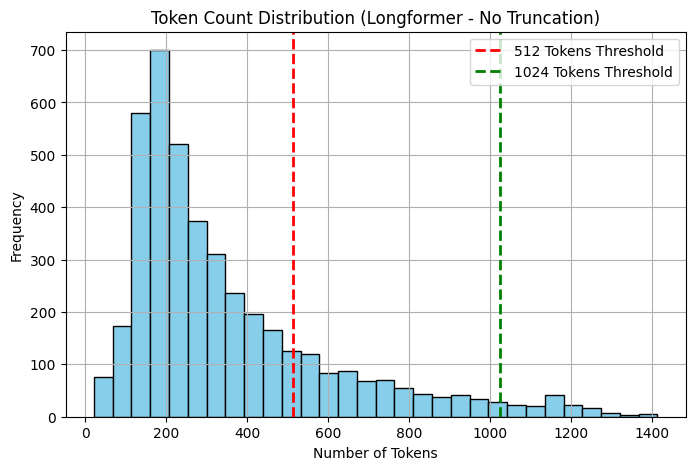

Number of entries exceeding 1024 tokens: 154


In [21]:
from transformers import LongformerTokenizerFast

# Initialize Longformer tokenizer
tokenizer3 = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096")

# Tokenize the dataset without truncation to capture full token counts
def tokenize_without_truncation(batch):
    return tokenizer3(batch["review_text"], padding=False, truncation=False)

# Tokenize the dataset
ds_encoded2 = ds.map(tokenize_without_truncation, batched=True, batch_size=None)

# Calculate token counts
ds_encoded2 = ds_encoded2.map(lambda x: {"token_count": len(x["input_ids"])})

# Extract token counts for plotting
token_counts3 = [entry['token_count'] for entry in ds_encoded2['train']]

# Plotting
plt.figure(figsize=(8, 5))
plt.hist(token_counts3, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='512 Tokens Threshold')
plt.axvline(x=1024, color='green', linestyle='--', linewidth=2, label='1024 Tokens Threshold')

plt.title('Token Count Distribution (Longformer - No Truncation)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Display entries exceeding 1024 tokens
exceeding_1024 = [entry for entry in ds_encoded2['train'] if entry['token_count'] > 1024]
print(f"Number of entries exceeding 1024 tokens: {len(exceeding_1024)}")


# **LONGFORMER**

In [42]:
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification

model_name2 = "allenai/longformer-base-4096"

tokenizer3 = LongformerTokenizerFast.from_pretrained(model_name2)

from transformers import LongformerConfig

# Define config specifically for Longformer
config = LongformerConfig.from_pretrained(
    model_name2,
    attention_window=[512] * 12,  # Standard Longformer setting
    output_hidden_states=False,
    num_labels=len(set(list(y_train) + list(y_test))),  # Ensure label size is correct
    label2id=label2id,
    id2label=id2label
)

model = LongformerForSequenceClassification.from_pretrained(
    model_name2,
    config=config
)

def tokenize_with_padding(batch):
    return tokenizer3(batch["review_text"],
                      padding=True,
                      truncation=True,
                      max_length=1024)  # Lowered to reduce memory footprint

ds_encoded2 = ds.map(tokenize_with_padding, batched=True)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer3)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./longformer-model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    weight_decay=0.01,
    num_train_epochs=4,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_f1",      # <-- Corrected to match `compute_metrics`
    greater_is_better=True                # Ensures higher F1 is considered better
)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


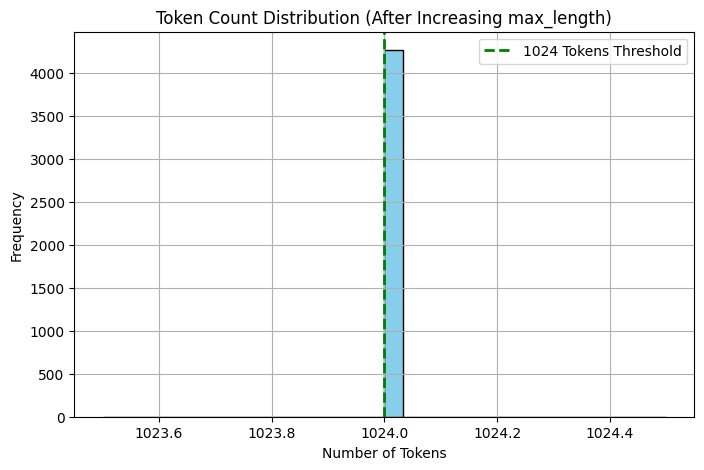

Number of entries exceeding 1024 tokens: 0


In [43]:
# Visualize token distribution again
token_counts = [len(x['input_ids']) for x in ds_encoded2['train']]

plt.figure(figsize=(8, 5))
plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=1024, color='green', linestyle='--', linewidth=2, label='1024 Tokens Threshold')
plt.title('Token Count Distribution (After Increasing max_length)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Display sequences exceeding 4096 tokens
exceeding_1024 = [x for x in ds_encoded2['train'] if len(x['input_ids']) > 1024]
print(f"Number of entries exceeding 1024 tokens: {len(exceeding_1024)}")


In [47]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Define a function to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    # Accuracy
    acc = accuracy_score(labels, preds)

    # Precision, Recall, and F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        'eval_loss': eval_pred[0].mean(),  # Added for early stopping
        'eval_accuracy': acc,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1  # <-- This MUST match `metric_for_best_model`
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded2["train"],
    eval_dataset=ds_encoded2["validation"],
    data_collator=DataCollatorWithPadding(tokenizer3),
    compute_metrics=compute_metrics  # Add this line for metrics
)


In [48]:
import torch
torch.cuda.empty_cache()

eval_metrics = trainer.evaluate(ds_encoded2["validation"])
print(eval_metrics)

{'eval_model_preparation_time': 0.0048, 'eval_runtime': 155.0544, 'eval_samples_per_second': 6.881, 'eval_steps_per_second': 3.444}


In [52]:
# Convert boolean 'is_spoiler' to integer labels (0 or 1)
def add_labels(batch):
    batch['labels'] = [int(x) for x in batch['is_spoiler']]  # Convert True/False to 1/0
    return batch

# Apply the fix with batching enabled
ds_encoded2 = ds_encoded2.map(add_labels, batched=True)

# Verify the fix
print(ds_encoded2["train"].features)
print(ds_encoded2["validation"].features)

Map:   0%|          | 0/4268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1067 [00:00<?, ? examples/s]

{'review_text': Value(dtype='string', id=None), 'is_spoiler': Value(dtype='bool', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
{'review_text': Value(dtype='string', id=None), 'is_spoiler': Value(dtype='bool', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [53]:
predictions_output = trainer.predict(ds_encoded2["validation"])

# Extract logits and labels
logits = predictions_output.predictions
labels = np.array(ds_encoded2["validation"]['labels'])

# Compute metrics manually
y_preds = np.argmax(logits, axis=1)

accuracy = accuracy_score(labels, y_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, y_preds, average='weighted'
)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.4967
Precision: 0.4946
Recall: 0.4967
F1 Score: 0.4621


In [54]:
print(trainer.args.metric_for_best_model)  # Should output: "eval_f1"
print(trainer.compute_metrics)             # Should confirm `compute_metrics` is present


eval_f1
<function compute_metrics at 0x7b3f2fd8eac0>


# **PREVIOUS VERSION**

In [ ]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

config = RobertaConfig.from_pretrained(
    model_name,
    output_hidden_states = False,
    num_labels           = len(set(list(y_train) + list(y_test))),
    label2id             = label2id,
    id2label             = id2label
)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(model_name, config=config)

batch_size                  = 16
gradient_accumulation_steps = 2

logging_steps = len(ds_encoded["train"]) // (batch_size * gradient_accumulation_steps)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the output directory where the model will be saved
OUTPUT_DIR = "./"  # You can change this to any valid directory

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
training_args = TrainingArguments(
    output_dir             = os.path.join(OUTPUT_DIR, 'roberta-model'),
    weight_decay           = 0.02,
    learning_rate          = 2e-5,
    evaluation_strategy    = "epoch",
    save_strategy          = 'epoch',
    num_train_epochs       = 3,
    logging_steps          = logging_steps,
    load_best_model_at_end = True,
    save_total_limit       = 2,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def model_init(): return RobertaForSequenceClassification.from_pretrained(model_name, config=config)

model = RobertaForSequenceClassification.from_pretrained(model_name, config=config)
model.to(device)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = ds_encoded["train"],
    eval_dataset    = ds_encoded["validation"],
    callbacks       = [EarlyStoppingCallback(early_stopping_patience = 2)],

    ###############################################
    # model_init      = model_init                #
    # model           = model                     #
    # compute_metrics = compute_metrics           #
    #                                             #
    # optimizers      = (optimizer, lr_scheduler) #
    ###############################################
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: linzyzach (linzyzach-university-of-cyprus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.639600,0.632486
2,0.491800,0.632021


TrainOutput(global_step=399, training_loss=0.5631148641868343, metrics={'train_runtime': 1310.1049, 'train_samples_per_second': 9.773, 'train_steps_per_second': 0.305, 'total_flos': 3348877512622080.0, 'train_loss': 0.5631148641868343, 'epoch': 2.9812734082397006})

In [ ]:
model = trainer.model

model.save_pretrained(os.path.join(OUTPUT_DIR, 'roberta-model/pretrained'), save_config=True)

trainer.evaluate(ds_encoded["validation"])

preds_output = trainer.predict(ds_encoded["validation"])

y_preds = np.argmax(preds_output.predictions, axis=1)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2714: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

print(f"F1 Score : {f1_score(y_test, y_preds)}")
print(f"Accuracy : {accuracy_score(y_test, y_preds)}")
print(f"Precision: {precision_score(y_test, y_preds)}")
print(f"Recall   : {recall_score(y_test, y_preds)}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_preds)}")

print(classification_report(y_test, y_preds))


F1 Score : 0.6413502109704642
Accuracy : 0.6813495782567948
Precision: 0.7307692307692307
Recall   : 0.5714285714285714
ROC AUC  : 0.681041388518024
              precision    recall  f1-score   support

       False       0.65      0.79      0.71       535
        True       0.73      0.57      0.64       532

    accuracy                           0.68      1067
   macro avg       0.69      0.68      0.68      1067
weighted avg       0.69      0.68      0.68      1067

